Project root added to system path. You can now import modules from the 'scripts' directory.
Data loaded successfully.

Training data length: 2028
Testing data length: 507

--- Training ARIMA Model ---
Finding optimal ARIMA parameters...


d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1

Optimal ARIMA parameters: (0, 1, 0)

--- Training LSTM Model ---
Training LSTM model...


d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10academy\week_11_time_series_forecasting_for_

LSTM model trained and saved successfully.
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

--- ARIMA Evaluation ---
MAE: 54.21
RMSE: 68.76
MAPE: 21.85%

--- LSTM Evaluation ---
MAE: 11.68
RMSE: 15.48
MAPE: 4.59%


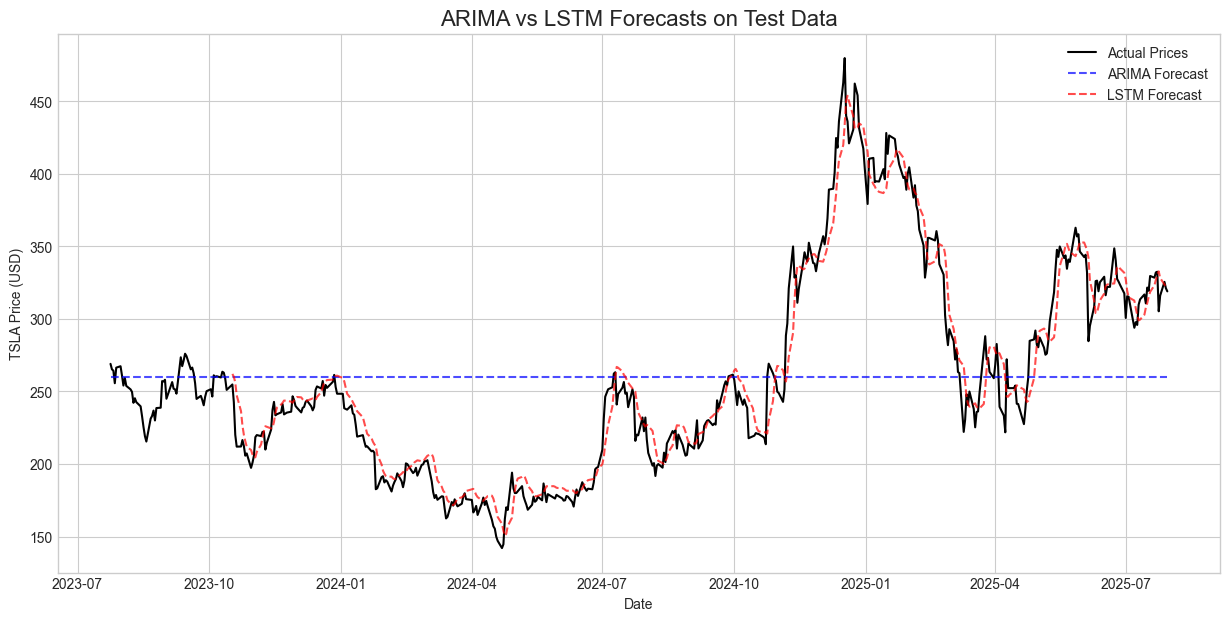

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import os
import sys

# --- FIX for ModuleNotFoundError ---
# Add the project's root directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
print("Project root added to system path. You can now import modules from the 'scripts' directory.")
# --- END FIX ---

from scripts.model_training import train_arima_model, train_lstm_model, create_sequences

plt.style.use('seaborn-v0_8-whitegrid')

# Load data from Task 1
try:
    returns_df = pd.read_csv('../data/processed/returns.csv', index_col=0, parse_dates=True)
    clean_prices = pd.read_csv('../data/processed/clean_prices.csv', index_col=0, parse_dates=True)
    tsla_data = clean_prices['TSLA']
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The necessary preprocessed files were not found.")
    print("Please ensure that task1_eda.ipynb has been run successfully.")
    raise

# Split data chronologically
train_size = int(len(tsla_data) * 0.8)
train_data, test_data = tsla_data[:train_size], tsla_data[train_size:]
print(f"\nTraining data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

# --- ARIMA Model Implementation ---
print("\n--- Training ARIMA Model ---")
model_arima_fit = train_arima_model(train_data)
arima_forecast = model_arima_fit.forecast(steps=len(test_data))
arima_forecast.index = test_data.index

# --- LSTM Model Implementation ---
print("\n--- Training LSTM Model ---")
seq_length = 60
model_lstm, scaler = train_lstm_model(train_data, seq_length)
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test_sequences, _ = create_sequences(scaled_test_data, seq_length)
X_test_sequences = X_test_sequences.reshape(X_test_sequences.shape[0], X_test_sequences.shape[1], 1)
lstm_predictions_scaled = model_lstm.predict(X_test_sequences)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test_data.index[seq_length:])
adjusted_test_data = test_data[seq_length:]

# --- Model Evaluation & Comparison ---
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n--- {model_name} Evaluation ---")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

evaluate_model(test_data, arima_forecast, "ARIMA")
evaluate_model(adjusted_test_data.values, lstm_predictions.values, "LSTM")

# Plotting comparison
plt.figure(figsize=(15, 7))
plt.plot(test_data.index, test_data, label='Actual Prices', color='black')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', alpha=0.7, color='blue', linestyle='--')
plt.plot(lstm_predictions.index, lstm_predictions, label='LSTM Forecast', alpha=0.7, color='red', linestyle='--')
plt.title('ARIMA vs LSTM Forecasts on Test Data', fontsize=16)
plt.xlabel('Date')
plt.ylabel('TSLA Price (USD)')
plt.legend()
plt.show()